## Iris Classification

In this notebook I will cover single label classification task in ML, I will implement different Machine Learning algorithms on the famous Iris Dataset.

I will not use the libraries to implement algorithms, the learning objective of this notebook to implement and evaluate different algorithms, to master both conceptual and technical details of ML algorithms. Also, this work will try to explain and visualise some latent spaces and basic ML reasoning about inference results.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

### Dataset

Here I will use the sklearn library to download the iris dataset.

In [2]:
iris = load_iris()

In [3]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In the data object of sklearn Iris dataset the label is not present, it is stored in the special `target` encoded to numerical codes, the following code will add the target values to the dataFrame.

In [4]:
df['species'] = iris.target

species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Initial Analysis

At this moment the dataset is loaded, so the exploratory analysis might be performed, we firstly want to get basic understanding of the data we are working with.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [6]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


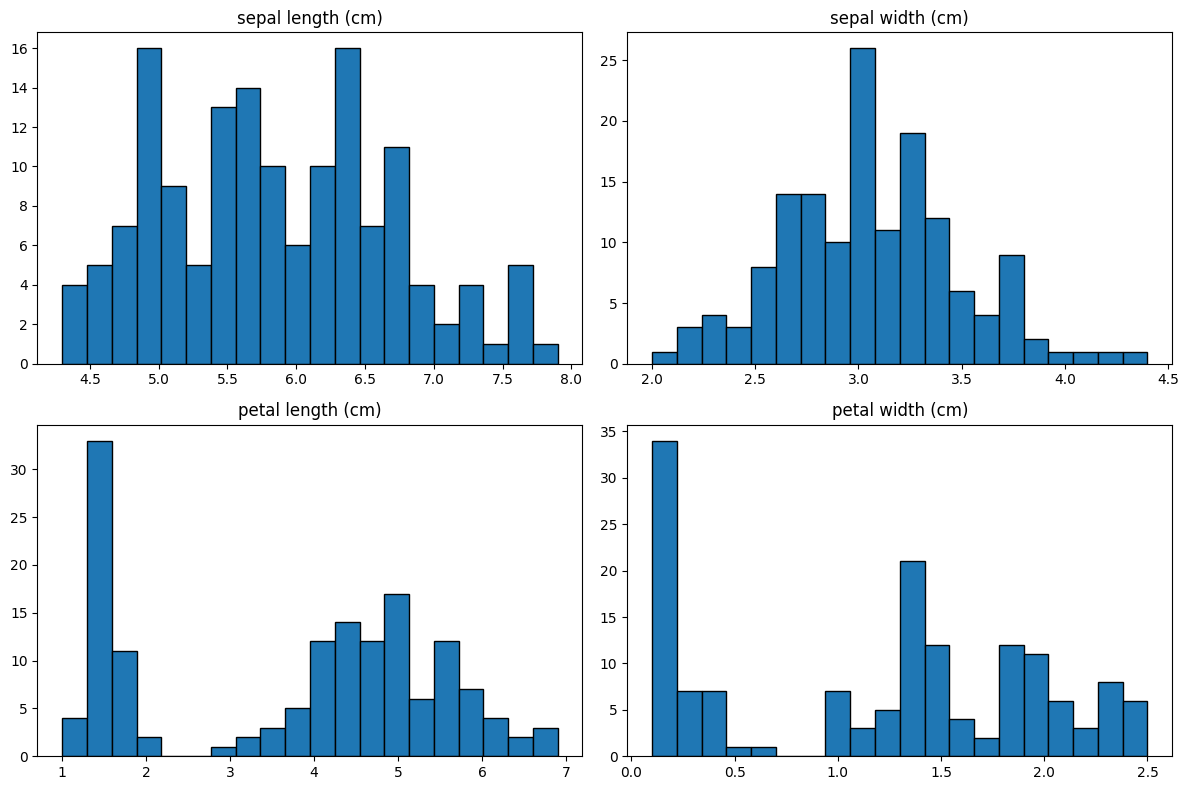

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axes.flatten(), df.columns):
    ax.hist(df[col], bins=20, edgecolor='black')
    ax.set_title(col)

plt.tight_layout()
plt.show()

From these histograms we could see that multiple data points are clearly separated by the petal measurements, lets plot histograms for each of the target classes to see if we could identify any insights of the data.

setosa


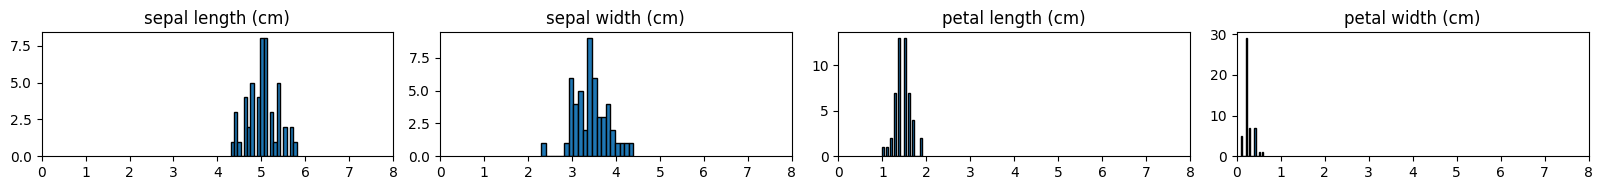

versicolor


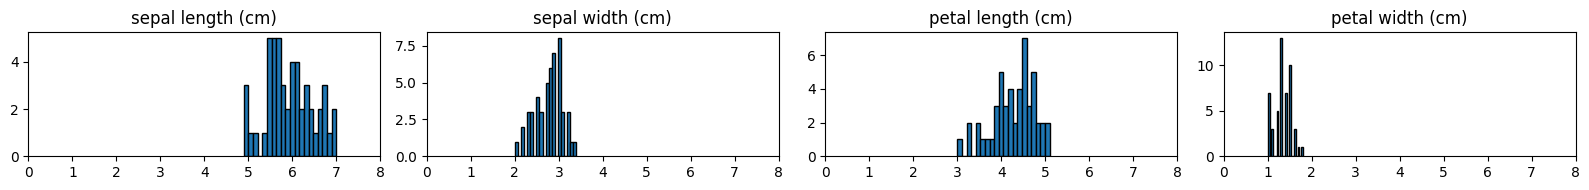

virginica


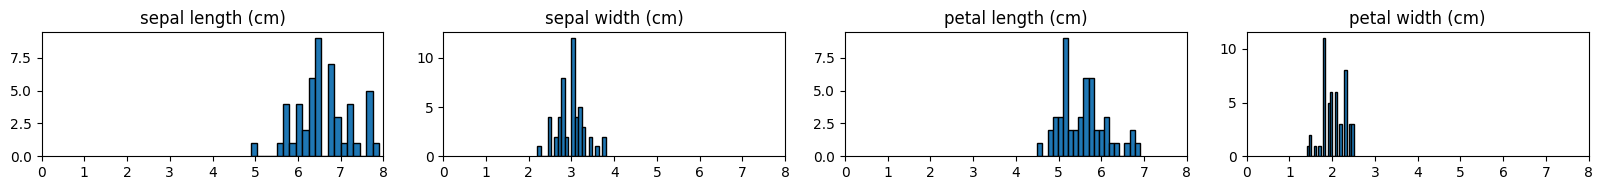

In [8]:
targets = df['species'].unique()

targets = df['species'].unique()

for target in targets:
    class_data = df[df['species'] == target]

    fig, axes = plt.subplots(1, 4, figsize=(16, 2))

    print(species_map[target])

    for ax, col in zip(axes.flatten(), df.columns[:-1]):
        ax.hist(class_data[col], bins=20, edgecolor='black')
        ax.set_title(col)
        ax.set_xlim(0,8)

    plt.tight_layout()
    plt.show()

With more precise plots, where all the measurements are shown individually for each class, the following observation are concluded:
1. Sepal width is almost identical for all classes;
2. Other variables follow same trend, where setose is the smallest item, then versicolor and virginica is the largest;
3. The trend described in point 2 is mainly visible in terms of petal both length and width

With this analysis now it is also possible to plot all the data points along with targets at once in the form that is possible for human to percept. Since the `sepal width` is almost the same for all classes, it is possible to plot 3d scatter plot approximation, based only on `sepal length`, `petal length` and `petal width`.

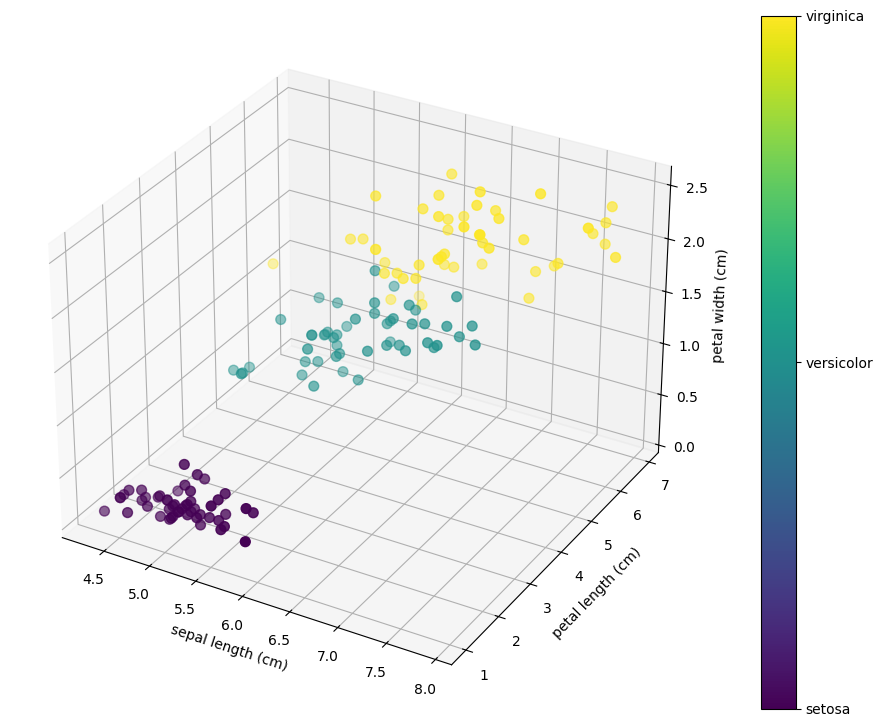

In [9]:
sepal_len = df["sepal length (cm)"]
petal_len = df["petal length (cm)"]
petal_width = df["petal width (cm)"]

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(sepal_len, petal_len, petal_width, c=df["species"], cmap='viridis', s=50)

ax.set_xlabel("sepal length (cm)")
ax.set_ylabel("petal length (cm)")
ax.set_zlabel("petal width (cm)")

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(species_map.values())


plt.show()

From the 3d Scatter Plot above it is clear that setosa form a separate cluster, then versicolor and virginica fall near each other, but with visual estimation, still form separate clusters. Such distribution lead us to the idea to implement `KNN` algorithm to solve this problem.

## Reusable functions and variables

Next the general methods will be defined, that should be reused in all the algorithms, it will include train, test dataset split and evaluation function that will be used to estimate the prediction metrics.

## Data Preparation

Firstly will prepare data into `X(inputs)` and `Y(targets)` and also perform train test split with factor `0.2`.

In [10]:
X = df.drop(columns=["species"]).values
y = df["species"].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Evaluation

Firstly the method to compute accuracy will be defined, at this moment this is the only metric that is going to be used to estimate algorithms.

In [11]:
def compute_accuracy(y_predicted, y_actual):
    accuracy = y_predicted == y_actual
    return np.mean(accuracy)


## KNN

K-Nearest Neighbors (KNN) is a non-parametric, supervised learning algorithm used for classification and regression tasks.

### How KNN Works (For Classification)

- Choose K (number of neighbors) – Typically an odd number to avoid ties.
- Measure Distance – Compute the distance (e.g., Euclidean) between the new data point and all training points.
- Find K Nearest Neighbors – Select the K closest points.
- Assign Class – The majority class among the K neighbors determines the new point's class.

### Why Use KNN?
- Simple and effective for small datasets.
- No training phase – works instantly by storing examples.
- Works well with clusters like the Iris dataset.


In [12]:
class KNN:
    def __init__(self, n_neighbors=3):
        self.k = n_neighbors

    def fit(self, X, y):
        self.points = np.array(X)
        self.targets = np.array(y)

    def predict(self, X):
        X = np.array(X)

        was_1d = False
        if X.ndim == 1:
            X = X.reshape(1, -1)
            was_1d = True

        distances = np.sum((X[:, np.newaxis, :] - self.points) ** 2, axis=2)

        nearest_indexes = np.argsort(distances, axis=1)[:, :self.k]

        nearest_targets = self.targets[nearest_indexes]

        predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=nearest_targets)

        return predictions[0] if was_1d else predictions


In [13]:
knn_alg = KNN()
knn_alg.fit(x_train, y_train)

predictions = knn_alg.predict(x_test)

In [15]:
knn_accuracy = compute_accuracy(predictions, y_test)
print("KNN accuracy: ", round(knn_accuracy, 5))

KNN accuracy:  0.9


## Logistic Regression

In [ ]:
class LogisticRegression:
    def __init__(self):
        self.w = np.zeros((4, 3))
        self.b = np.zeros((1,3))

    def softmax(self, x):
        x = x - np.max(x, axis=1, keepdims=True)
        exp = np.exp(x)
        return exp / np.sum(exp, axis=1, keepdims=True)

    def loss(self, logits, y):
        p = self.softmax(logits)
        log_likelihood = -np.log(p[np.arange(len(y)), y])
        return np.mean(log_likelihood)

    def forward(self, x):
        self.w = np.dot(x, self.w) + self.b

    def backward(self, pred, targets):


    def train(self, X, y):
        x = np.array(X)
        y = np.array(y)



